# Adding Gaussian noise to $f$-domain CSEM data

The standard deviation is defined in emg3d in the following way,
$
\varsigma = \sqrt{\epsilon_\text{n}^2 + \left(\epsilon_\text{r}|d|\right)^2 } \, ,
$
where $\epsilon_\text{n}$ is the noise floor, $\epsilon_\text{r}$ is the relative error, and $d$ the data.

The imaginary number $z$ is given by
$
z = x + \text{i}y = ae^{\text{i}\phi} \, .
$

We now define our "observed" data as Gaussian-random realizations of the true values, in three different ways, where $\mathcal{N}$ is the standard normal distribution, hence zero mean and a standard deviation of one. You might want to add an additive signal to give it a non-zero mean.

1. Add independent, random noise separately to Real and Imaginary part

    $
    \Re = x + \varsigma\,\mathcal{N} \, ,\\
    \Im = y + \varsigma\,\mathcal{N} \, .
    $


2. Add independent, random noise separately to Amplitude and Phase

    $
    A = |z| + \varsigma\,\mathcal{N} \, ,\\
    \phi = \arctan(y/x) + \varsigma/|z|\,\mathcal{N} \, .
    $
    

3. Add complex noise to complex number

    $
    Z = z + \sqrt{2}\,\varsigma\,\exp(\text{i}\mathcal{N}) \, .
    $
    

**References**
- https://mare2dem.bitbucket.io/uncertainty.html#data-uncertainties.
- Wheelock B., S. Constable, and K. Key, 2015, GJI; DOI: https://doi.org/10.1093/gji/ggv107.


In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Some settings for both cases

In [2]:
# Phase settings: wrapped, radians, lag-defined (+iw)
phase = {'unwrap': False, 'deg': False, 'lag': True}


# Helper functions that mask the negative (positive) values with NaN for plotting
def pos(resp):
    """Return resp, where negative values of resp are set to NaN."""
    return np.array([x if x > 0 else np.nan for x in resp])


def neg(resp):
    """Return -resp, where positive values of resp are set to NaN."""
    return np.array([-x if x < 0 else np.nan for x in resp])


def rel_error(resp, noise):
    """Return relative error (%) of noise with respect to resp."""
    return 100*abs((noise-resp)/resp)

## Functions related to noise computation

In [3]:
# Relative error, noise floor, and random function
rel_err = 0.05
noise_floor = 1e-15
gaussian = np.random.default_rng().standard_normal


def standard_deviation(resp):
    """Return Standard deviation given resp."""
    return np.sqrt(noise_floor**2 + (rel_err*resp.amp())**2)


def add_to_reim(resp):
    """Add noise to Real/Imaginary part of resp."""
    std = standard_deviation(resp)
    noise_re = std*gaussian(resp.size)  # Noise real part
    noise_im = std*gaussian(resp.size)  # Noise imaginary part
    return resp + noise_re + 1j*noise_im
# targetn = target*(1 + mask) + maskn

def add_to_amph(resp):
    """Add noise to Amplitude/Phase of resp."""
    std = standard_deviation(resp)
    noise_amp = resp.amp() + std*gaussian(resp.size)                    # Amplitude + noise amplitude
    noise_pha = resp.pha(**phase) + std*gaussian(resp.size)/resp.amp()  # Phase     + noise phase
    # Return complex values from phase and amplitude
    return noise_amp*(np.cos(noise_pha) + 1j*np.sin(noise_pha))


def add_to_comp(resp):
    """Add complex noise to complex resp."""
    std = standard_deviation(resp)
    return resp + np.sqrt(2)*std*np.exp(1j*gaussian(resp.size))

# 1. Offset-range for single frequency

## Generate data

In [4]:
# Offsets
offs = np.linspace(1000, 10000, 201)
freq = 1
res = 3

# Responses
oresp = empymod.dipole(
    src=(0, 0, 0),        # src at origin
    rec=(offs, offs*0, 0),  # Inline receivers, 1-10 km
    depth=[],             # Homogenous space
    res=res,              # 3 Ohm.m
    freqtime=freq,        # 1 Hz
    ab=11,                # Ex-source, Ex-receiver
)

# Add noise to Real/Imaginary
onoise_reim = add_to_reim(oresp)

# Add noise to Amplitude/Phase
onoise_amph = add_to_amph(oresp)

# Add noise to complex number
onoise_comp = add_to_comp(oresp)


:: empymod END; runtime = 0:00:00.242108 :: 1 kernel call(s)



## Plot

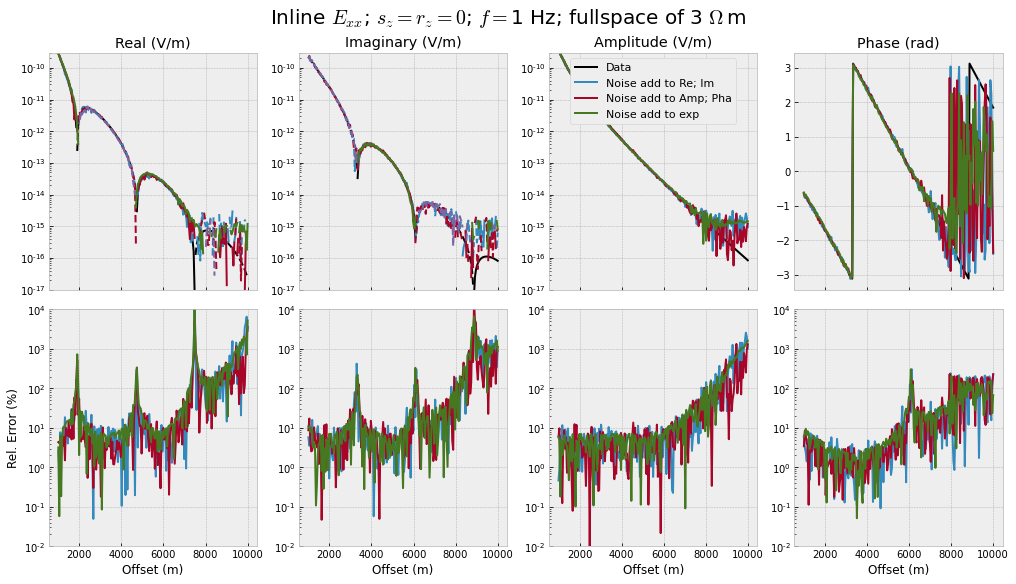

In [5]:
fig, axs = plt.subplots(2, 4, constrained_layout=True, figsize=(14, 8), sharex=True)
fig.suptitle(f"Inline $E_{{xx}}$; $s_z=r_z=0$; $f=${freq} Hz; fullspace of {res} $\Omega\,$m", fontsize=20)

axs[0, 0].set_title('Real (V/m)')
axs[0, 0].plot(offs, pos(oresp.real), 'k')
axs[0, 0].plot(offs, neg(oresp.real), 'k--')
axs[0, 0].plot(offs, pos(onoise_reim.real), 'C0')
axs[0, 0].plot(offs, neg(onoise_reim.real), 'C0--')
axs[0, 0].plot(offs, pos(onoise_amph.real), 'C1')
axs[0, 0].plot(offs, neg(onoise_amph.real), 'C1--')
axs[0, 0].plot(offs, pos(onoise_comp.real), 'C3')
axs[0, 0].plot(offs, neg(onoise_comp.real), 'C2--')
axs[0, 0].set_yscale('log')

axs[1, 0].plot(offs, rel_error(oresp.real, onoise_reim.real), 'C0')
axs[1, 0].plot(offs, rel_error(oresp.real, onoise_amph.real), 'C1')
axs[1, 0].plot(offs, rel_error(oresp.real, onoise_comp.real), 'C3')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Offset (m)')
axs[1, 0].set_ylabel('Rel. Error (%)')

axs[0, 1].set_title('Imaginary (V/m)')
axs[0, 1].plot(offs, pos(oresp.imag), 'k')
axs[0, 1].plot(offs, neg(oresp.imag), 'k--')
axs[0, 1].plot(offs, pos(onoise_reim.imag), 'C0')
axs[0, 1].plot(offs, neg(onoise_reim.imag), 'C0--')
axs[0, 1].plot(offs, pos(onoise_amph.imag), 'C1')
axs[0, 1].plot(offs, neg(onoise_amph.imag), 'C1--')
axs[0, 1].plot(offs, pos(onoise_comp.imag), 'C3')
axs[0, 1].plot(offs, neg(onoise_comp.imag), 'C2--')
axs[0, 1].set_yscale('log')

axs[1, 1].plot(offs, rel_error(oresp.imag, onoise_reim.imag), 'C0')
axs[1, 1].plot(offs, rel_error(oresp.imag, onoise_amph.imag), 'C1')
axs[1, 1].plot(offs, rel_error(oresp.imag, onoise_comp.imag), 'C3')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Offset (m)')

axs[0, 2].set_title('Amplitude (V/m)')
axs[0, 2].plot(offs, oresp.amp(), 'k', label='Data')
axs[0, 2].plot(offs, onoise_reim.amp(), 'C0', label='Noise add to Re; Im')
axs[0, 2].plot(offs, onoise_amph.amp(), 'C1', label='Noise add to Amp; Pha')
axs[0, 2].plot(offs, onoise_comp.amp(), 'C3', label='Noise add to exp')
axs[0, 2].set_yscale('log')
axs[0, 2].legend(loc='upper center', fontsize=11, framealpha=1)

axs[1, 2].plot(offs, rel_error(oresp.amp(), onoise_reim.amp()), 'C0')
axs[1, 2].plot(offs, rel_error(oresp.amp(), onoise_amph.amp()), 'C1')
axs[1, 2].plot(offs, rel_error(oresp.amp(), onoise_comp.amp()), 'C3')
axs[1, 2].set_yscale('log')
axs[1, 2].set_xlabel('Offset (m)')

axs[0, 3].set_title('Phase (rad)')
axs[0, 3].plot(offs, oresp.pha(**phase), 'k')
axs[0, 3].plot(offs, onoise_reim.pha(**phase), 'C0')
axs[0, 3].plot(offs, onoise_amph.pha(**phase), 'C1')
axs[0, 3].plot(offs, onoise_comp.pha(**phase), 'C3')

axs[1, 3].plot(offs, rel_error(oresp.pha(**phase), onoise_reim.pha(**phase)), 'C0')
axs[1, 3].plot(offs, rel_error(oresp.pha(**phase), onoise_amph.pha(**phase)), 'C1')
axs[1, 3].plot(offs, rel_error(oresp.pha(**phase), onoise_comp.pha(**phase)), 'C3')
axs[1, 3].set_yscale('log')
axs[1, 3].set_xlabel('Offset (m)')

for i in range(3):
    axs[0, i].set_ylim([1e-17, 3e-10])

for i in range(4):
    axs[1, i].set_ylim([1e-2, 1e4])

# 2. Frequency-range for single offset

## Generate data

In [6]:
# Frequencies
freqs = np.logspace(-3, 2, 201)
off = 5000

# fresponses
fresp = empymod.dipole(
    src=(0, 0, 0),        # src at origin
    rec=(5000, 0, 0),     # Inline receiver at 5 km
    depth=[],             # Homogenous space
    res=res,                # 3 Ohm.m
    freqtime=freqs,       # 0.001-100 Hz
    ab=11,                # Ex-source, Ex-receiver
)

# Add noise to Real/Imaginary
fnoise_reim = add_to_reim(fresp)

# Add noise to Amplitude/Phase
fnoise_amph = add_to_amph(fresp)

# Add noise to complex number
fnoise_comp = add_to_comp(fresp)


:: empymod END; runtime = 0:00:00.009299 :: 1 kernel call(s)



## Plot

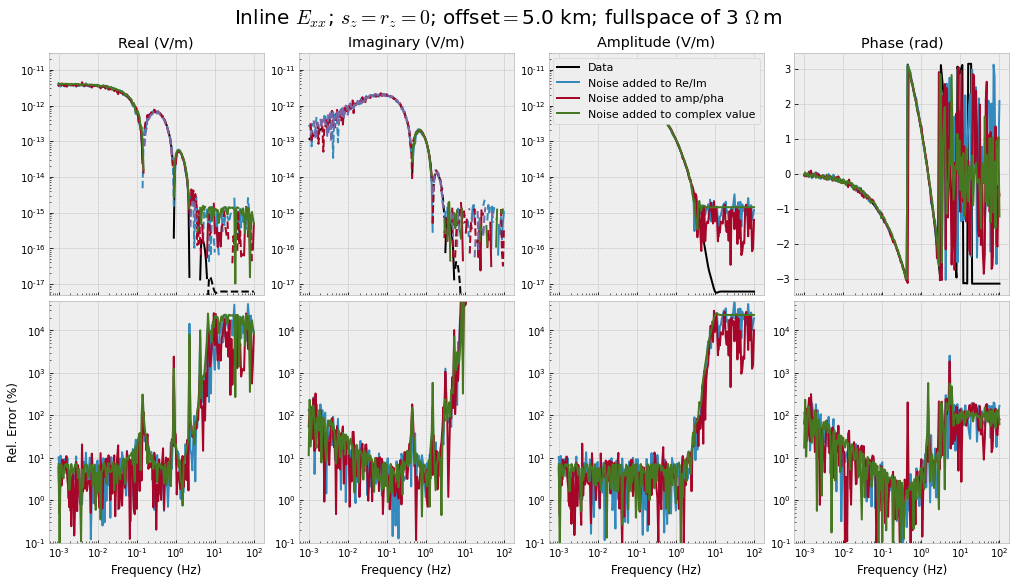

In [7]:
fig, axs = plt.subplots(2, 4, constrained_layout=True, figsize=(14, 8), sharex=True)
fig.suptitle(f"Inline $E_{{xx}}$; $s_z=r_z=0$; offset$=${off/1e3} km; fullspace of {res} $\Omega\,$m", fontsize=20)

axs[0, 0].set_title('Real (V/m)')
axs[0, 0].plot(freqs, pos(fresp.real), 'k')
axs[0, 0].plot(freqs, neg(fresp.real), 'k--')
axs[0, 0].plot(freqs, pos(fnoise_reim.real), 'C0')
axs[0, 0].plot(freqs, neg(fnoise_reim.real), 'C0--')
axs[0, 0].plot(freqs, pos(fnoise_amph.real), 'C1')
axs[0, 0].plot(freqs, neg(fnoise_amph.real), 'C1--')
axs[0, 0].plot(freqs, pos(fnoise_comp.real), 'C3')
axs[0, 0].plot(freqs, neg(fnoise_comp.real), 'C2--')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')

axs[1, 0].plot(freqs, rel_error(fresp.real, fnoise_reim.real), 'C0')
axs[1, 0].plot(freqs, rel_error(fresp.real, fnoise_amph.real), 'C1')
axs[1, 0].plot(freqs, rel_error(fresp.real, fnoise_comp.real), 'C3')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Frequency (Hz)')
axs[1, 0].set_ylabel('Rel. Error (%)')

axs[0, 1].set_title('Imaginary (V/m)')
axs[0, 1].plot(freqs, pos(fresp.imag), 'k')
axs[0, 1].plot(freqs, neg(fresp.imag), 'k--')
axs[0, 1].plot(freqs, pos(fnoise_reim.imag), 'C0')
axs[0, 1].plot(freqs, neg(fnoise_reim.imag), 'C0--')
axs[0, 1].plot(freqs, pos(fnoise_amph.imag), 'C1')
axs[0, 1].plot(freqs, neg(fnoise_amph.imag), 'C1--')
axs[0, 1].plot(freqs, pos(fnoise_comp.imag), 'C3')
axs[0, 1].plot(freqs, neg(fnoise_comp.imag), 'C2--')
axs[0, 1].set_yscale('log')

axs[1, 1].plot(freqs, rel_error(fresp.imag, fnoise_reim.imag), 'C0')
axs[1, 1].plot(freqs, rel_error(fresp.imag, fnoise_amph.imag), 'C1')
axs[1, 1].plot(freqs, rel_error(fresp.imag, fnoise_comp.imag), 'C3')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Frequency (Hz)')

axs[0, 2].set_title('Amplitude (V/m)')
axs[0, 2].plot(freqs, fresp.amp(), 'k', label='Data')
axs[0, 2].plot(freqs, fnoise_reim.amp(), 'C0', label='Noise added to Re/Im')
axs[0, 2].plot(freqs, fnoise_amph.amp(), 'C1', label='Noise added to amp/pha')
axs[0, 2].plot(freqs, fnoise_comp.amp(), 'C3', label='Noise added to complex value')
axs[0, 2].set_yscale('log')
axs[0, 2].legend(loc='upper center', fontsize=11, framealpha=1)

axs[1, 2].plot(freqs, rel_error(fresp.amp(), fnoise_reim.amp()), 'C0')
axs[1, 2].plot(freqs, rel_error(fresp.amp(), fnoise_amph.amp()), 'C1')
axs[1, 2].plot(freqs, rel_error(fresp.amp(), fnoise_comp.amp()), 'C3')
axs[1, 2].set_yscale('log')
axs[1, 2].set_xlabel('Frequency (Hz)')

axs[0, 3].set_title('Phase (rad)')
axs[0, 3].plot(freqs, fresp.pha(**phase), 'k')
axs[0, 3].plot(freqs, fnoise_reim.pha(**phase), 'C0')
axs[0, 3].plot(freqs, fnoise_amph.pha(**phase), 'C1')
axs[0, 3].plot(freqs, fnoise_comp.pha(**phase), 'C3')

axs[1, 3].plot(freqs, rel_error(fresp.pha(**phase), fnoise_reim.pha(**phase)), 'C0')
axs[1, 3].plot(freqs, rel_error(fresp.pha(**phase), fnoise_amph.pha(**phase)), 'C1')
axs[1, 3].plot(freqs, rel_error(fresp.pha(**phase), fnoise_comp.pha(**phase)), 'C3')
axs[1, 3].set_yscale('log')
axs[1, 3].set_xlabel('Frequency (Hz)')

for i in range(3):
    axs[0, i].set_ylim([5e-18, 3e-11])

for i in range(4):
    axs[1, i].set_ylim([1e-1, 5e4])

The three responses with added noise look very similar, roughly speaking, no matter if we added independent noiso to real and imaginary part, or to amplitude or phase, or generated complex noise.

The only real difference is that with the complex noise, the amplitude is flat in the frequency-spectrum, and the phase is random. This is what we would expect of white noise. 

In [8]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Thu Jul 15 22:40:23 2021 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter

  Python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27)
  [GCC 9.3.0]

             numpy : 1.20.2
             scipy : 1.7.0
             numba : 0.53.0
           empymod : 2.1.2
           IPython : 7.23.1
        matplotlib : 3.4.2

  Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------